# Jupyter notebook analyzing synaptic properties of GluA1, GluA4, Stg, PSD95, and NR1 in 2023.07 PV-GFP dataset

Last edited by MES on 9/1/24

In [1]:
#import relevant packages
import os
import numpy as np
#from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
import scanpy as sc
import anndata
#import leidenalg
#import igraph as ig
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy import stats
import scipy.io as sio

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def unique(list1): 
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set))
    return unique_list

In [4]:
parentdir = '/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/2023.07_PV-GFP_5target/'

In [5]:
filenames = os.listdir(parentdir)
csvs = [filename for filename in filenames if filename.endswith('csv')]

In [6]:
csvs

['2023.07_PV-GFP_ExR_results_20240718.csv',
 'ca1_selectedvsunselected_lmer_pvals.csv',
 'ssc_selectedvsunselected_lmer_pvals.csv']

In [7]:
mats = [filename for filename in filenames if filename.endswith('mat')]

In [8]:
mats

['analyzed_data_nofilt_20240830.mat']

In [9]:
matfile = sio.loadmat('analyzed_data_nofilt_20240830.mat',squeeze_me=True)

In [10]:
sorted(matfile.keys())

['__globals__', '__header__', '__version__', 'data']

In [11]:
matdata = matfile['data']

In [12]:
matdata

array((array(['CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn1',
       'CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn2',
       'CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn3', ...,
       array([], dtype=float64), array([], dtype=float64),
       array([], dtype=float64)], dtype=object), array([0.00000000e+00, 6.39879393e-05, 1.09020961e-03, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00]), array([  0.        , 666.88679245, 764.82281285, ...,   0.        ,
         0.        ,   0.        ]), array([0, 1, 1, ..., 0, 0, 0], dtype=uint8), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), array([  0.        ,  67.45229008, 565.16775777, ...,   0.        ,
         0.        ,   0.        ])),
      dtype=[('names', 'O'), ('total_vol', 'O'), ('mean_int', 'O'), ('npuncta', 'O'), ('selected_tf', 'O'), ('mean_int_refnorm', 'O')])

In [13]:
names = matdata['names'].item().tolist()

In [14]:
vols = matdata['total_vol'].item()
vols = np.reshape(vols, (vols.shape[0],1))

In [15]:
ints = matdata['mean_int'].item()
ints = np.reshape(ints, (ints.shape[0],1))

In [16]:
ns = matdata['npuncta'].item()
ns = np.reshape(ns, (ns.shape[0],1))

In [17]:
ints_refnorm = matdata['mean_int_refnorm'].item()
ints_refnorm = np.reshape(ints_refnorm, (ints_refnorm.shape[0],1))

In [18]:
selected_tfs = matdata['selected_tf'].item()
selected_tfs = np.reshape(selected_tfs, (selected_tfs.shape[0],1))

In [19]:
data_array = np.concatenate((vols,ints,ints_refnorm,ns,selected_tfs), axis=1)

In [20]:
data_array.shape

(170500, 5)

In [21]:
data = pd.DataFrame(data_array,index=names,
                    columns=['target_vol','target_meanint','target_meanint_refnorm','target_npuncta','selected_tf'])

In [22]:
data.tail(10)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0
[],0.0,0.0,0.0,0.0,0.0


In [23]:
data = data[data.index != '[]']

In [24]:
data

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn1,0.000000,0.000000,0.000000,0.0,0.0
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn2,0.000064,666.886792,67.452290,1.0,0.0
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn3,0.001090,764.822813,565.167758,1.0,0.0
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn4,0.000000,0.000000,0.000000,0.0,0.0
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn5,0.000062,908.980392,36.132502,2.0,0.0
...,...,...,...,...,...
SSC_33-2-8_Stg_fov40x025_50steps(1-50)_pp_syn192,0.000000,0.000000,0.000000,0.0,0.0
SSC_33-2-8_Stg_fov40x025_50steps(1-50)_pp_syn193,0.000058,233.833333,11.179283,1.0,0.0
SSC_33-2-8_Stg_fov40x025_50steps(1-50)_pp_syn194,0.000477,300.503797,106.075961,1.0,0.0
SSC_33-2-8_Stg_fov40x025_50steps(1-50)_pp_syn195,0.000078,283.046154,38.978814,1.0,0.0


In [25]:
data.shape

(36894, 5)

In [26]:
data.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn1,0.000000,0.000000,0.000000,0.0,0.0
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn2,0.000064,666.886792,67.452290,1.0,0.0
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn3,0.001090,764.822813,565.167758,1.0,0.0
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn4,0.000000,0.000000,0.000000,0.0,0.0
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn5,0.000062,908.980392,36.132502,2.0,0.0


In [27]:
#How many synapses were selected?
data['selected_tf'].value_counts()

selected_tf
0.0    33940
1.0     2954
Name: count, dtype: int64

## 1. Add metadata

In [28]:
samples = []
regions = []
roi_fulls = []
fovs = [] 
syns = []
prots = []

for idx,row in data.iterrows():
    splits = idx.split("_")

    reg = splits[0]
    sample = splits[1]
    prot = splits[2]
    
    fov = splits[3]
    roi_full = sample + "-" + prot + "-" + fov
    syn = splits[6]
    
    samples.append(sample)
    regions.append(reg)
    roi_fulls.append(roi_full)
    fovs.append(fov)
    syns.append(syn)
    prots.append(prot)

In [29]:
unique(samples)

['32-1-7', '33-1-7', '32-2-8', '33-2-8']

In [30]:
unique(regions)

['SSC', 'CA1']

In [31]:
data['sample'] = samples
data['region'] = regions
data['roi_full'] = roi_fulls
data['fov'] = fovs
data['syn'] = syns
data['prot'] = prots

In [32]:
data.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn1,0.000000,0.000000,0.000000,0.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn1,GluA1
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn2,0.000064,666.886792,67.452290,1.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn2,GluA1
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn3,0.001090,764.822813,565.167758,1.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn3,GluA1
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn4,0.000000,0.000000,0.000000,0.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn4,GluA1
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn5,0.000062,908.980392,36.132502,2.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn5,GluA1


In [33]:
data.shape

(36894, 11)

In [34]:
selected_yns = []
for idx,row in data.iterrows():
    if row['selected_tf']:
        selected_yns.append('selected')
    else:
        selected_yns.append('unselected')

In [35]:
data['group']=selected_yns

## 1. GluA4

In [36]:
data_a4 = data[data['prot']=='GluA4']

<Axes: xlabel='target_vol', ylabel='Count'>

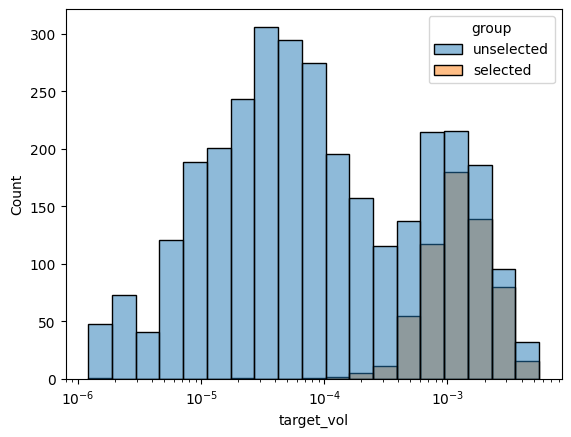

In [37]:
sns.histplot(data_a4, x='target_vol', hue='group',log_scale=True)

<Axes: ylabel='target_vol'>

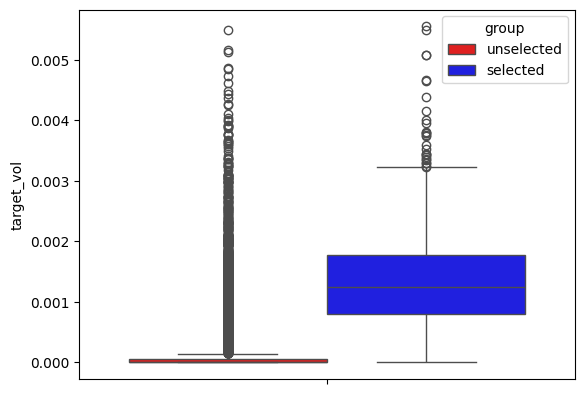

In [38]:
sns.boxplot(data_a4, y="target_vol", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint', ylabel='Count'>

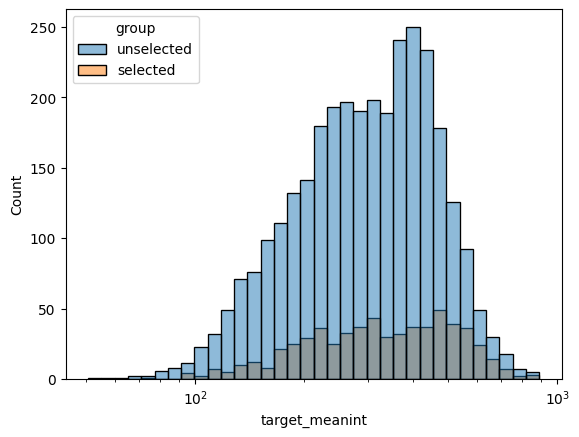

In [39]:
sns.histplot(data_a4, x='target_meanint', hue='group', log_scale=True)

<Axes: ylabel='target_meanint'>

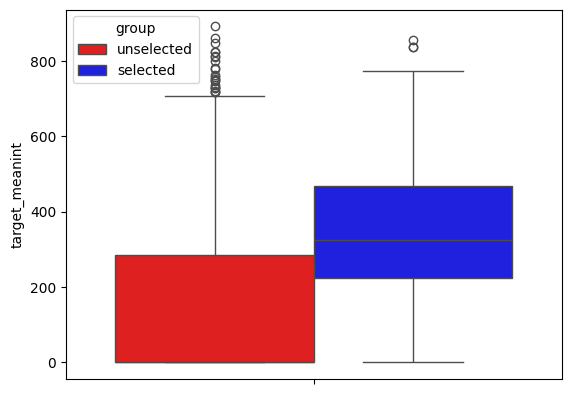

In [40]:
sns.boxplot(data_a4, y="target_meanint", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint_refnorm', ylabel='Count'>

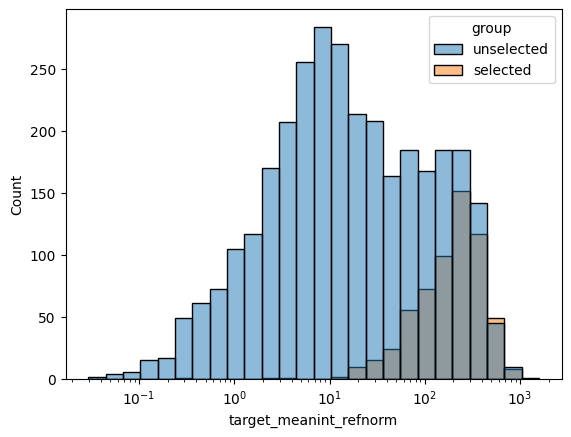

In [41]:
sns.histplot(data_a4, x='target_meanint_refnorm', hue='group', log_scale=True)

<Axes: ylabel='target_meanint_refnorm'>

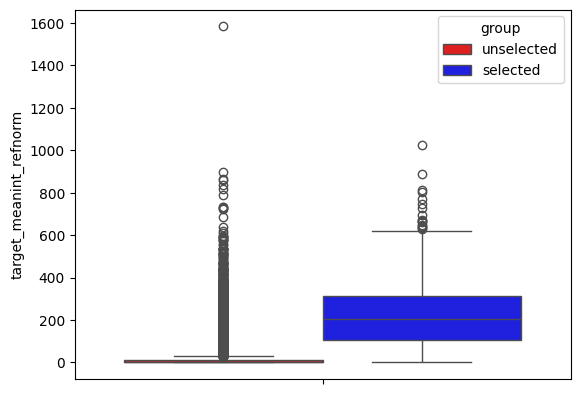

In [42]:
sns.boxplot(data_a4, y="target_meanint_refnorm", hue="group",palette=['red','blue'])

## 2. Stg

In [43]:
data_stg = data[data['prot']=='Stg']

<Axes: xlabel='target_vol', ylabel='Count'>

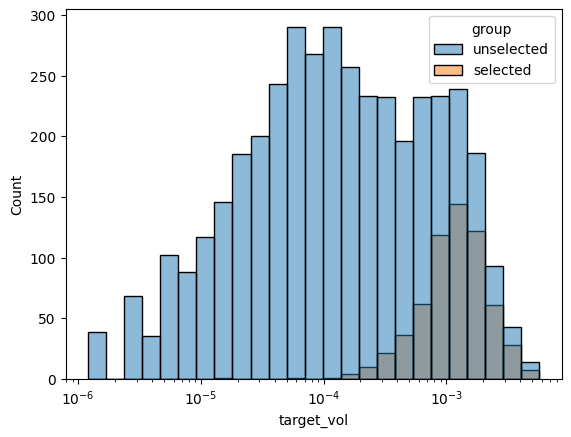

In [44]:
sns.histplot(data_stg, x='target_vol', hue='group',log_scale=True)

<Axes: ylabel='target_vol'>

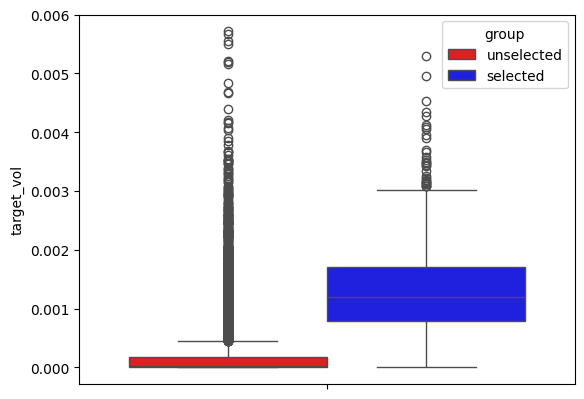

In [45]:
sns.boxplot(data_stg, y="target_vol", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint', ylabel='Count'>

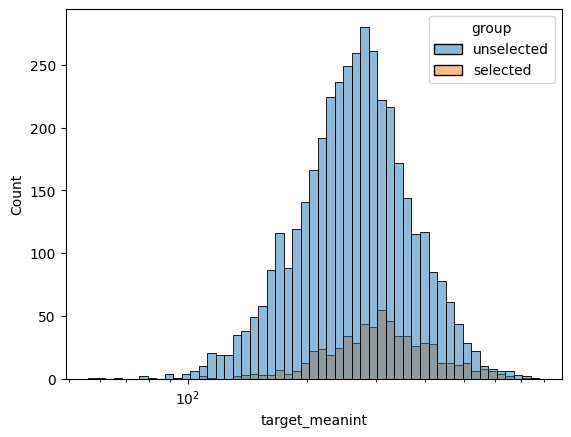

In [46]:
sns.histplot(data_stg, x='target_meanint', hue='group', log_scale=True)

<Axes: ylabel='target_meanint'>

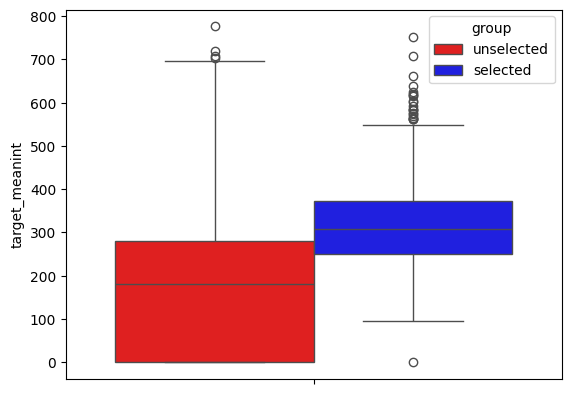

In [47]:
sns.boxplot(data_stg, y="target_meanint", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint_refnorm', ylabel='Count'>

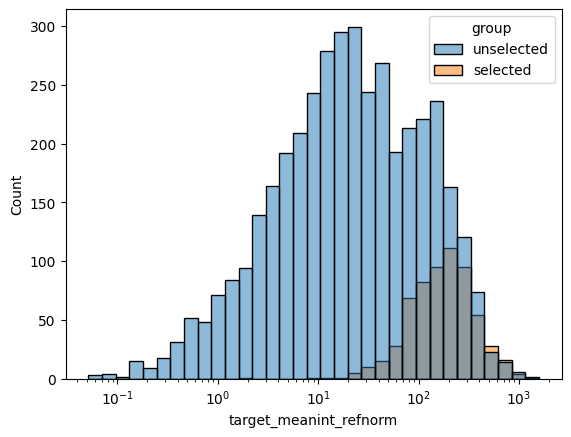

In [48]:
sns.histplot(data_stg, x='target_meanint_refnorm', hue='group', log_scale=True)

<Axes: ylabel='target_meanint_refnorm'>

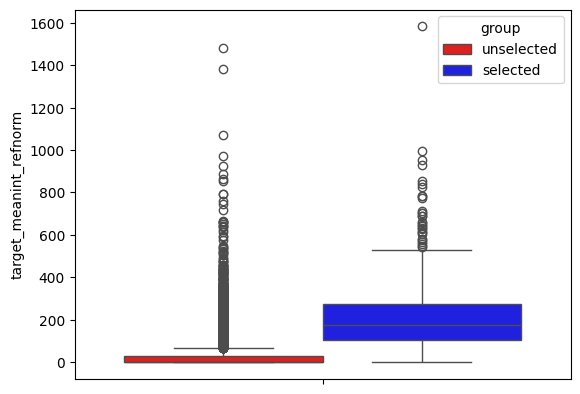

In [49]:
sns.boxplot(data_stg, y="target_meanint_refnorm", hue="group",palette=['red','blue'])

## 3. PSD95

In [50]:
data_95 = data[data['prot']=='PSD95']

<Axes: xlabel='target_vol', ylabel='Count'>

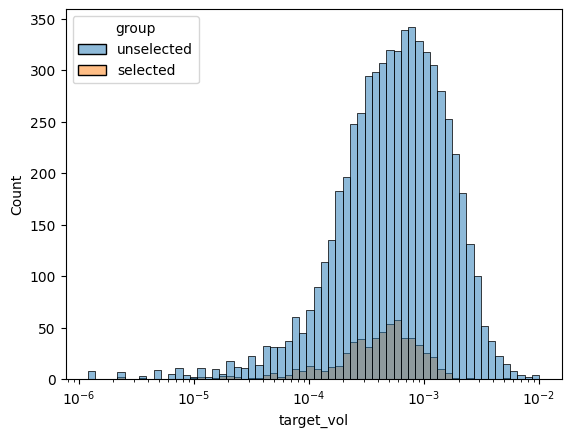

In [51]:
sns.histplot(data_95, x='target_vol', hue='group',log_scale=True)

<Axes: ylabel='target_vol'>

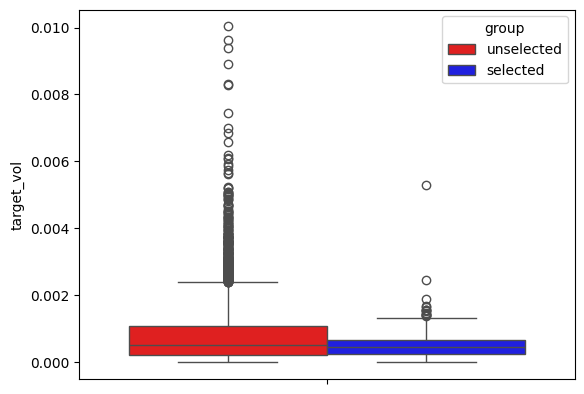

In [52]:
sns.boxplot(data_95, y="target_vol", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint', ylabel='Count'>

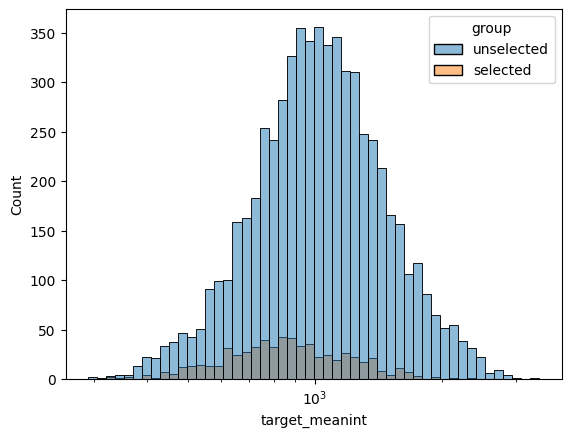

In [53]:
sns.histplot(data_95, x='target_meanint', hue='group', log_scale=True)

<Axes: ylabel='target_meanint'>

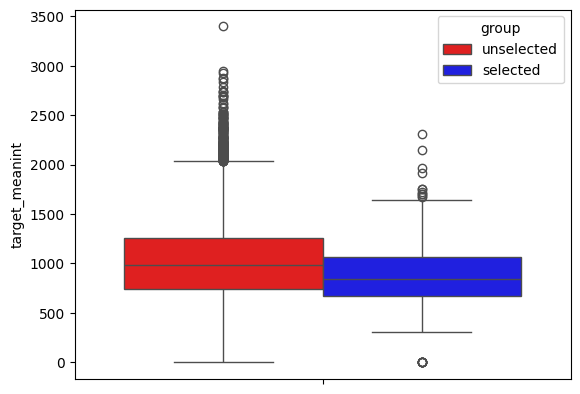

In [54]:
sns.boxplot(data_95, y="target_meanint", hue="group",palette=['red','blue'])

<Axes: xlabel='target_meanint_refnorm', ylabel='Count'>

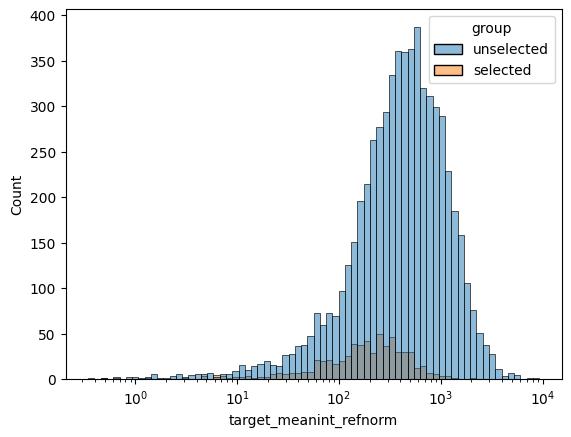

In [55]:
sns.histplot(data_95, x='target_meanint_refnorm', hue='group', log_scale=True)

<Axes: ylabel='target_meanint_refnorm'>

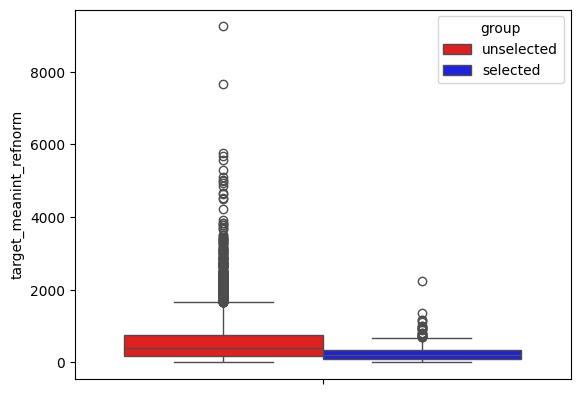

In [56]:
sns.boxplot(data_95, y="target_meanint_refnorm", hue="group",palette=['red','blue'])

## Create scatter plots of volume vs. mean intensity

<Axes: xlabel='target_vol', ylabel='target_meanint'>

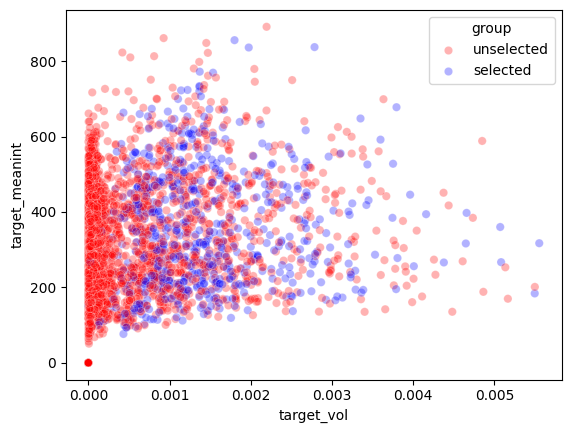

In [57]:
sns.scatterplot(data_a4,x='target_vol',y='target_meanint',hue="group",palette=['red','blue'],alpha=0.3)

# Test for statistically significant differences in these properties between synapse types

In [58]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [59]:
list(data)

['target_vol',
 'target_meanint',
 'target_meanint_refnorm',
 'target_npuncta',
 'selected_tf',
 'sample',
 'region',
 'roi_full',
 'fov',
 'syn',
 'prot',
 'group']

In [60]:
#approximate new alpha?
0.05 / (4*4)

0.003125

In [61]:
unadjusted_pvals = []
zscores = []

## 1. SSC

In [62]:
data_ctx = data[data['region']=='SSC']

In [63]:
data_ctx.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot,group
SSC_32-1-7_GluA4_fov40x000_50steps(5-54)_pp_syn1,0.000000,0.0000,0.000000,0.0,0.0,32-1-7,SSC,32-1-7-GluA4-fov40x000,fov40x000,syn1,GluA4,unselected
SSC_32-1-7_GluA4_fov40x000_50steps(5-54)_pp_syn2,0.000000,0.0000,0.000000,0.0,0.0,32-1-7,SSC,32-1-7-GluA4-fov40x000,fov40x000,syn2,GluA4,unselected
SSC_32-1-7_GluA4_fov40x000_50steps(5-54)_pp_syn3,0.000019,243.4375,1.941675,2.0,0.0,32-1-7,SSC,32-1-7-GluA4-fov40x000,fov40x000,syn3,GluA4,unselected
SSC_32-1-7_GluA4_fov40x000_50steps(5-54)_pp_syn4,0.000000,0.0000,0.000000,0.0,0.0,32-1-7,SSC,32-1-7-GluA4-fov40x000,fov40x000,syn4,GluA4,unselected
SSC_32-1-7_GluA4_fov40x000_50steps(5-54)_pp_syn5,0.000000,0.0000,0.000000,0.0,0.0,32-1-7,SSC,32-1-7-GluA4-fov40x000,fov40x000,syn5,GluA4,unselected


In [64]:
data_ctx['prot'].value_counts()

prot
GluA4    3391
PSD95    3129
NR1      3106
GluA1    3089
Stg      3042
Name: count, dtype: int64

### 1. GluA4

In [65]:
data_ctx_a4 = data_ctx[data_ctx['prot']=='GluA4']

In [66]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_a4, groups=data_ctx_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    3391      Method:               REML      
No. Groups:          16        Scale:                0.0000    
Min. group size:     142       Log-Likelihood:       20172.1693
Max. group size:     263       Converged:            Yes       
Mean group size:     211.9                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.002    0.000  32.777 0.000  0.001  0.002
group[T.unselected] -0.001    0.000 -31.640 0.000 -0.001 -0.001
Group Var            0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [67]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.2691188597969313e-235
1.0387215750126023e-219


In [68]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_a4, groups=data_ctx_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:  3391    Method:             REML                  
No. Groups:        16      Scale:              4275.1772             
Min. group size:   142     Log-Likelihood:     -18999.7031           
Max. group size:   263     Converged:          Yes                   
Mean group size:   211.9                                             
---------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept            153.643    5.236  29.344 0.000  143.381  163.906
group[T.unselected] -132.175    4.200 -31.469 0.000 -140.407 -123.943
Group Var            179.391    1.114                                



In [69]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.877564743096656e-189
2.302413376266156e-217


### 2. GluA1

In [70]:
data_ctx_a1 = data_ctx[data_ctx['prot']=='GluA1']

In [71]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_a1, groups=data_ctx_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    3089      Method:               REML      
No. Groups:          16        Scale:                0.0000    
Min. group size:     138       Log-Likelihood:       18912.9137
Max. group size:     260       Converged:            Yes       
Mean group size:     193.1                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.001    0.000  19.929 0.000  0.001  0.001
group[T.unselected] -0.000    0.000 -11.792 0.000 -0.001 -0.000
Group Var            0.000    0.000                            



In [72]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.2875505383443365e-88
4.279377915341424e-32


In [73]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_a1, groups=data_ctx_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 3089    Method:             REML                  
No. Groups:       16      Scale:              21625.1098            
Min. group size:  138     Log-Likelihood:     -19818.2720           
Max. group size:  260     Converged:          Yes                   
Mean group size:  193.1                                             
--------------------------------------------------------------------
                      Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------
Intercept             179.640   17.091 10.511 0.000  146.142 213.139
group[T.unselected]  -100.600   10.690 -9.411 0.000 -121.551 -79.648
Group Var            2966.563    7.663                              



In [74]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

7.726381553871419e-26
4.917295231024742e-21


### 3. PSD95

In [75]:
data_ctx_95 = data_ctx[data_ctx['prot']=='PSD95']

In [76]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_95, groups=data_ctx_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  target_vol
No. Observations:   3129     Method:              REML      
No. Groups:         15       Scale:               0.0000    
Min. group size:    147      Log-Likelihood:      16992.1043
Max. group size:    256      Converged:           Yes       
Mean group size:    208.6                                   
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.000    0.000 5.948 0.000  0.000  0.001
group[T.unselected] 0.001    0.000 7.934 0.000  0.000  0.001
Group Var           0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [77]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.7119030723150928e-09
2.1269138911948093e-15


In [78]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_95, groups=data_ctx_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 3129    Method:             REML                  
No. Groups:       15      Scale:              421784.0759           
Min. group size:  147     Log-Likelihood:     -24719.2800           
Max. group size:  256     Converged:          Yes                   
Mean group size:  208.6                                             
--------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              166.932   79.301  2.105 0.035  11.506 322.359
group[T.unselected]    462.885   43.692 10.594 0.000 377.251 548.520
Group Var            67913.112   40.808                             



In [79]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.03528688166606186
3.166449954196031e-26


### 4. NR1

In [80]:
data_ctx_nr1 = data_ctx[data_ctx['prot']=='NR1']

In [81]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_nr1, groups=data_ctx_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    3106      Method:               REML      
No. Groups:          15        Scale:                0.0000    
Min. group size:     175       Log-Likelihood:       18904.5698
Max. group size:     234       Converged:            Yes       
Mean group size:     207.1                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.001    0.000  22.556 0.000  0.001  0.001
group[T.unselected] -0.000    0.000 -11.235 0.000 -0.001 -0.000
Group Var            0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [82]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.1661887670949496e-112
2.7427963472786966e-29


In [83]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_nr1, groups=data_ctx_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 3106    Method:             REML                  
No. Groups:       15      Scale:              62311.7513            
Min. group size:  175     Log-Likelihood:     -21561.8202           
Max. group size:  234     Converged:          Yes                   
Mean group size:  207.1                                             
--------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              220.969   22.535  9.806 0.000 176.801 265.136
group[T.unselected]    -40.345   18.052 -2.235 0.025 -75.726  -4.963
Group Var             3054.881    5.113                             



In [84]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.064235438026296e-22
0.025425192519645864


### 5. Stargazin

In [85]:
data_ctx_stg = data_ctx[data_ctx['prot']=='Stg']

In [86]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ctx_stg, groups=data_ctx_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    3042      Method:               REML      
No. Groups:          16        Scale:                0.0000    
Min. group size:     144       Log-Likelihood:       17825.9158
Max. group size:     234       Converged:            Yes       
Mean group size:     190.1                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.002    0.000  36.477 0.000  0.002  0.002
group[T.unselected] -0.001    0.000 -29.850 0.000 -0.002 -0.001
Group Var            0.000    0.000                            



In [87]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.5289543057231816e-291
8.728275527013475e-196


In [88]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ctx_stg, groups=data_ctx_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:  3042    Method:             REML                  
No. Groups:        16      Scale:              8958.8828             
Min. group size:   144     Log-Likelihood:     -18166.5390           
Max. group size:   234     Converged:          Yes                   
Mean group size:   190.1                                             
---------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept            214.843    7.429  28.918 0.000  200.282  229.405
group[T.unselected] -170.362    6.555 -25.990 0.000 -183.210 -157.515
Group Var            247.185    1.119                                



In [89]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

7.087634842044727e-184
6.394540498846361e-149


#### Compile p-values

In [90]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
      'GluA1_vol',
    'GluA1_meanint_refnorm',
        'PSD95_vol',
    'PSD95_meanint_refnorm',
        'NR1_vol',
    'NR1_meanint_refnorm',
        'Stg_vol',
    'Stg_meanint_refnorm',
]

In [91]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [92]:
pvals_df['zscore_unselected'] = zscores

### Create bar plots for each of these measures

#### Adjust p-values

In [93]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv(parentdir + 'ssc_selectedvsunselected_lmer_pvals.csv')

In [94]:
prots = unique(data['prot'])

In [95]:
prots

['GluA1', 'NR1', 'GluA4', 'Stg', 'PSD95']

In [96]:
values = ['target_vol','target_meanint_refnorm']

In [97]:
group_colors = ['blue','red']

In [98]:
pvals_df

,p_unadjusted,zscore_unselected,p_adjusted,significant
GluA4_vol,1.038722e-219,-31.639999,1.038722e-218,True
GluA4_meanint_refnorm,2.302413e-217,-31.469000,1.151207e-216,True
GluA1_vol,4.279378e-32,-11.792000,8.558756e-32,True
GluA1_meanint_refnorm,4.917295e-21,-9.411000,6.146619e-21,True
PSD95_vol,2.126914e-15,7.934000,2.363238e-15,True
PSD95_meanint_refnorm,3.166450e-26,10.594000,4.523500e-26,True
NR1_vol,2.742796e-29,-11.235000,4.571327e-29,True
NR1_meanint_refnorm,2.542519e-02,-2.235000,2.542519e-02,True
Stg_vol,8.728276e-196,-29.850000,2.909425e-195,True
Stg_meanint_refnorm,6.394540e-149,-25.990000,1.598635e-148,True


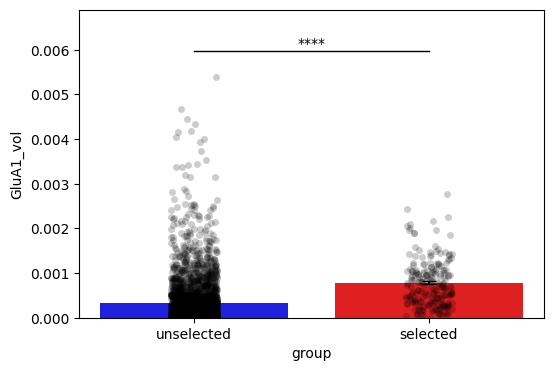

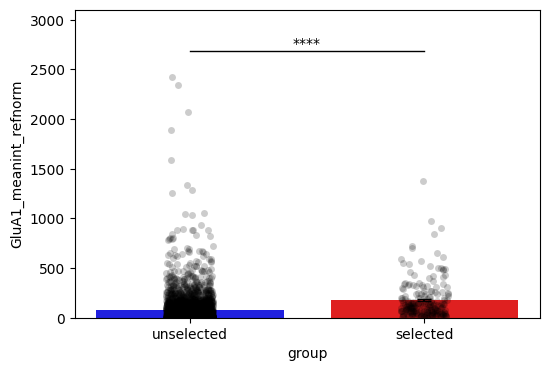

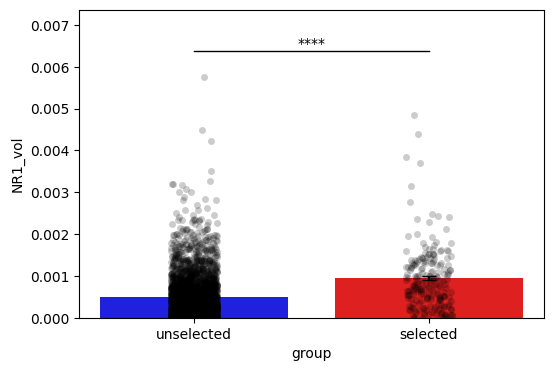

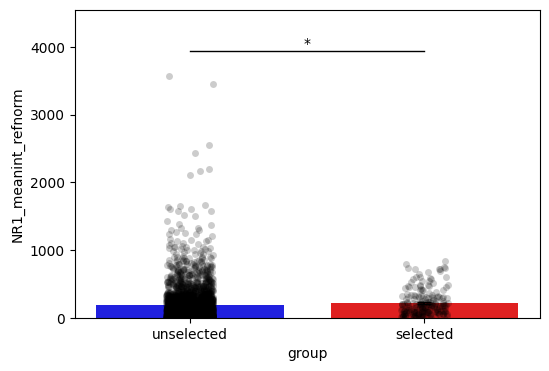

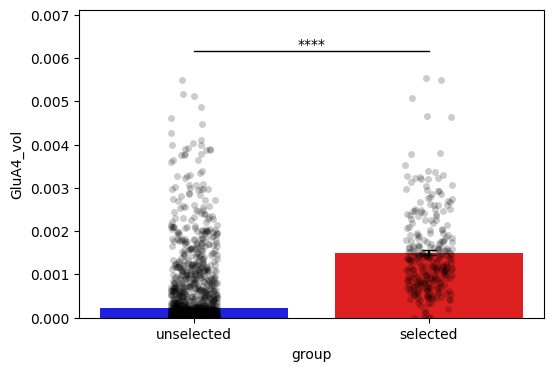

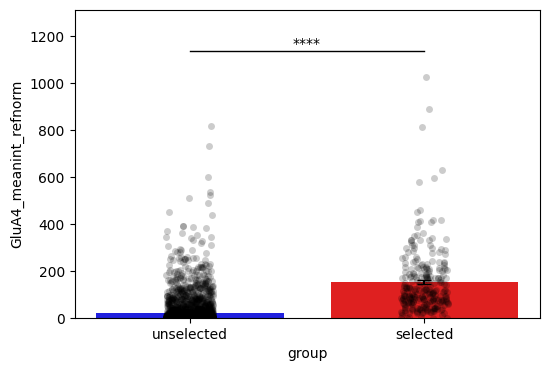

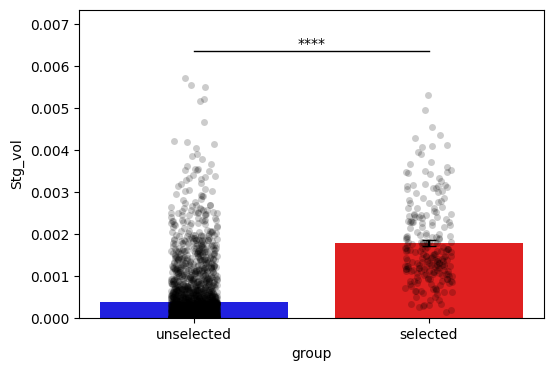

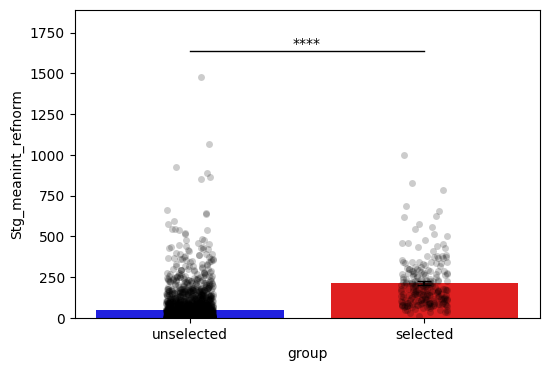

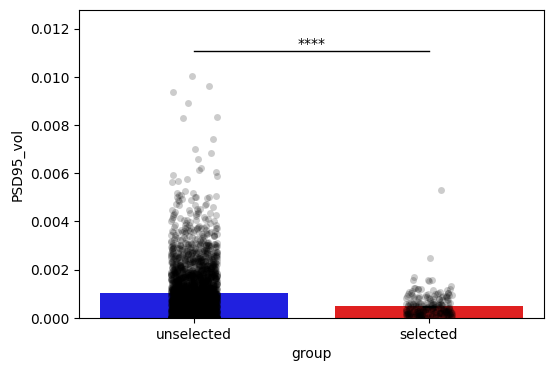

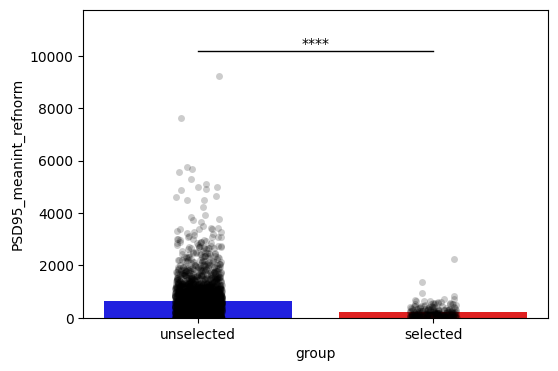

In [99]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Assuming your data_ctxFrame with data_ctx is named 'data_ctx'
# and the data frame with significance information is named 'pvals_df'
# pvals_df should have an index matching the numerical variable names in 'data_ctx'

# Example data_ctxFrames (uncomment and adjust according to your actual data_ctx)
# data_ctx = pd.read_csv('your_data_ctx.csv')
# pvals_df = pd.read_csv('your_significance_data_ctx.csv')

# Identify numerical columns in 'data_ctx'
numerical_columns = data_ctx.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ctx['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ctx[data_ctx['prot']==prot]
        plt.figure(figsize=(6, 4))
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ctx points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/SSC_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/SSC_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

## 2. CA1

In [100]:
unadjusted_pvals = []
zscores = []

In [101]:
data_ca1 = data[data['region']=='CA1']

In [102]:
data_ca1.head(5)

,target_vol,target_meanint,target_meanint_refnorm,target_npuncta,selected_tf,sample,region,roi_full,fov,syn,prot,group
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn1,0.000000,0.000000,0.000000,0.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn1,GluA1,unselected
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn2,0.000064,666.886792,67.452290,1.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn2,GluA1,unselected
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn3,0.001090,764.822813,565.167758,1.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn3,GluA1,unselected
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn4,0.000000,0.000000,0.000000,0.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn4,GluA1,unselected
CA1_32-1-7_GluA1_fov012_crop50(6-55)_pp_syn5,0.000062,908.980392,36.132502,2.0,0.0,32-1-7,CA1,32-1-7-GluA1-fov012,fov012,syn5,GluA1,unselected


In [103]:
data_ca1['prot'].value_counts()

prot
Stg      4591
PSD95    4266
NR1      4134
GluA4    4102
GluA1    4044
Name: count, dtype: int64

### 1. GluA4

In [104]:
data_ca1_a4 = data_ca1[data_ca1['prot']=='GluA4']

In [105]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_a4, groups=data_ca1_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    4102      Method:               REML      
No. Groups:          15        Scale:                0.0000    
Min. group size:     227       Log-Likelihood:       24892.8250
Max. group size:     293       Converged:            Yes       
Mean group size:     273.5                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.001    0.000  42.568 0.000  0.001  0.001
group[T.unselected] -0.001    0.000 -38.058 0.000 -0.001 -0.001
Group Var            0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [106]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.0
0.0


In [107]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_a4, groups=data_ca1_a4["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:  4102    Method:             REML                  
No. Groups:        15      Scale:              12233.7493            
Min. group size:   227     Log-Likelihood:     -25127.9622           
Max. group size:   293     Converged:          Yes                   
Mean group size:   273.5                                             
---------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept            289.813    6.504  44.556 0.000  277.064  302.561
group[T.unselected] -250.179    6.176 -40.506 0.000 -262.284 -238.073
Group Var            111.943    0.536                                



In [108]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.0
0.0


### 2. GluA1

In [109]:
data_ca1_a1 = data_ca1[data_ca1['prot']=='GluA1']

In [110]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_a1, groups=data_ca1_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    4044      Method:               REML      
No. Groups:          16        Scale:                0.0000    
Min. group size:     113       Log-Likelihood:       24410.5171
Max. group size:     317       Converged:            Yes       
Mean group size:     252.8                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.001    0.000  28.311 0.000  0.001  0.001
group[T.unselected] -0.001    0.000 -21.933 0.000 -0.001 -0.001
Group Var            0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [111]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.54293929019465e-176
1.2634561372222206e-106


In [112]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_a1, groups=data_ca1_a1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:   4044    Method:             REML                  
No. Groups:         16      Scale:              94773.6603            
Min. group size:    113     Log-Likelihood:     -28932.3597           
Max. group size:    317     Converged:          Yes                   
Mean group size:    252.8                                             
----------------------------------------------------------------------
                      Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------
Intercept             538.341   41.239  13.054 0.000  457.515  619.168
group[T.unselected]  -302.177   16.901 -17.879 0.000 -335.303 -269.051
Group Var           23100.986   28.283                                



In [113]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

6.010579781829029e-39
1.7199327412616539e-71


### 3. PSD95

In [114]:
data_ca1_95 = data_ca1[data_ca1['prot']=='PSD95']

In [115]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_95, groups=data_ca1_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  target_vol
No. Observations:    4266     Method:              REML      
No. Groups:          15       Scale:               0.0000    
Min. group size:     255      Log-Likelihood:      25849.7751
Max. group size:     325      Converged:           Yes       
Mean group size:     284.4                                   
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.001    0.000 17.083 0.000  0.000  0.001
group[T.unselected] 0.000    0.000  2.356 0.018  0.000  0.000
Group Var           0.000    0.000                           



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [116]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

1.988857908065548e-65
0.01848568574803985


In [117]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_95, groups=data_ca1_95["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 4266    Method:             REML                  
No. Groups:       15      Scale:              210393.0353           
Min. group size:  255     Log-Likelihood:     -32209.4004           
Max. group size:  325     Converged:          Yes                   
Mean group size:  284.4                                             
--------------------------------------------------------------------
                        Coef.   Std.Err.   z   P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept               266.412   38.106 6.991 0.000 191.726 341.098
group[T.unselected]     213.378   24.853 8.585 0.000 164.667 262.090
Group Var             13332.961   11.632                            



In [118]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.7222608680801384e-12
9.044854928642392e-18


### 4. NR1

In [119]:
data_ca1_nr1 = data_ca1[data_ca1['prot']=='NR1']

In [120]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_nr1, groups=data_ca1_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  target_vol
No. Observations:   4134     Method:              REML      
No. Groups:         15       Scale:               0.0000    
Min. group size:    220      Log-Likelihood:      27337.4912
Max. group size:    323      Converged:           Yes       
Mean group size:    275.6                                   
------------------------------------------------------------
                    Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept           0.000    0.000 9.233 0.000  0.000  0.000
group[T.unselected] 0.000    0.000 6.366 0.000  0.000  0.000
Group Var           0.000    0.000                          



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [121]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.6265342096245173e-20
1.9339544490840448e-10


In [122]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_nr1, groups=data_ca1_nr1["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: target_meanint_refnorm
No. Observations: 4134    Method:             REML                  
No. Groups:       15      Scale:              74968.7179            
Min. group size:  220     Log-Likelihood:     -29086.6831           
Max. group size:  323     Converged:          Yes                   
Mean group size:  275.6                                             
--------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              109.050   31.405  3.472 0.001  47.498 170.602
group[T.unselected]    177.767   16.145 11.010 0.000 146.123 209.412
Group Var            11191.062   15.886                             



In [123]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

0.0005157857439173269
3.401297689008215e-28


### 5. Stargazin

In [124]:
data_ca1_stg = data_ca1[data_ca1['prot']=='Stg']

In [125]:
# Run mixed lm for target
md = smf.mixedlm("target_vol ~ group", data_ca1_stg, groups=data_ca1_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   target_vol
No. Observations:    4591      Method:               REML      
No. Groups:          16        Scale:                0.0000    
Min. group size:     257       Log-Likelihood:       28492.2011
Max. group size:     328       Converged:            Yes       
Mean group size:     286.9                                     
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            0.001    0.000  37.534 0.000  0.001  0.001
group[T.unselected] -0.001    0.000 -35.577 0.000 -0.001 -0.001
Group Var            0.000    0.000                            



/Users/margaret/miniconda3/envs/scanpy_new/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [126]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

2.598906552661876e-308
3.23456906412799e-277


In [127]:
# Run mixed lm for target mean intensity, normalized to reference
md = smf.mixedlm("target_meanint_refnorm ~ group", data_ca1_stg, groups=data_ca1_stg["roi_full"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: target_meanint_refnorm
No. Observations:  4591    Method:             REML                  
No. Groups:        16      Scale:              8400.9497             
Min. group size:   257     Log-Likelihood:     -27272.4993           
Max. group size:   328     Converged:          Yes                   
Mean group size:   286.9                                             
---------------------------------------------------------------------
                     Coef.   Std.Err.    z    P>|z|  [0.025   0.975] 
---------------------------------------------------------------------
Intercept            214.905    6.932  31.001 0.000  201.318  228.491
group[T.unselected] -184.531    4.866 -37.921 0.000 -194.069 -174.994
Group Var            422.279    1.803                                



In [128]:
for x in range (0, 2):
    print(mdf.pvalues[x])
unadjusted_pvals.append(mdf.pvalues[1]) #add this p-value to the vector for adjustment later

params_table = mdf.summary().tables[1] #got line from ChatGPT
zscores.append(np.float32(params_table['z'][1]))#add the zscore to vector to have it for the pval table

5.242539687680927e-211
0.0


#### Compile p-values

In [129]:
pvals_df_index = [
    'GluA4_vol',
    'GluA4_meanint_refnorm',
      'GluA1_vol',
    'GluA1_meanint_refnorm',
        'PSD95_vol',
    'PSD95_meanint_refnorm',
        'NR1_vol',
    'NR1_meanint_refnorm',
        'Stg_vol',
    'Stg_meanint_refnorm',
]

In [130]:
pvals_df = pd.DataFrame(unadjusted_pvals,index=pvals_df_index,columns=['p_unadjusted'])

In [131]:
pvals_df['zscore_unselected'] = zscores

### Create bar plots for each of these measures

#### Adjust p-values

In [132]:
pvals_df['p_adjusted'] = stats.false_discovery_control(pvals_df['p_unadjusted'])
pvals_df['significant'] = pvals_df['p_adjusted'] < 0.05
pvals_df.to_csv(parentdir + 'ca1_selectedvsunselected_lmer_pvals.csv')

In [133]:
prots = unique(data['prot'])

In [134]:
prots

['GluA1', 'NR1', 'GluA4', 'Stg', 'PSD95']

In [135]:
values = ['target_vol','target_meanint_refnorm']

In [136]:
group_colors = ['blue','red']

In [137]:
pvals_df

,p_unadjusted,zscore_unselected,p_adjusted,significant
GluA4_vol,0.000000e+00,-38.057999,0.000000e+00,True
GluA4_meanint_refnorm,0.000000e+00,-40.506001,0.000000e+00,True
GluA1_vol,1.263456e-106,-21.933001,2.526912e-106,True
GluA1_meanint_refnorm,1.719933e-71,-17.879000,2.866555e-71,True
PSD95_vol,1.848569e-02,2.356000,1.848569e-02,True
PSD95_meanint_refnorm,9.044855e-18,8.585000,1.130607e-17,True
NR1_vol,1.933954e-10,6.366000,2.148838e-10,True
NR1_meanint_refnorm,3.401298e-28,11.010000,4.858997e-28,True
Stg_vol,3.234569e-277,-35.577000,8.086423e-277,True
Stg_meanint_refnorm,0.000000e+00,-37.921001,0.000000e+00,True


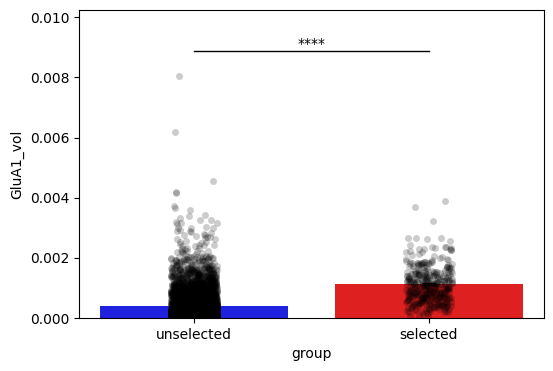

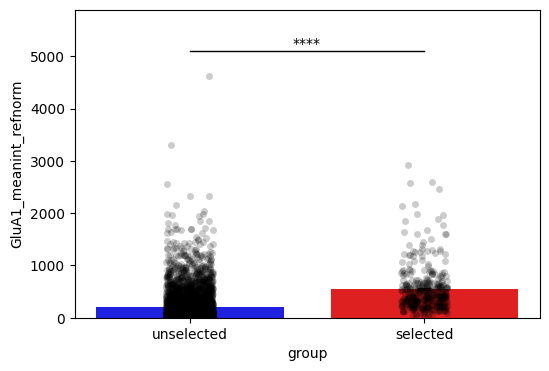

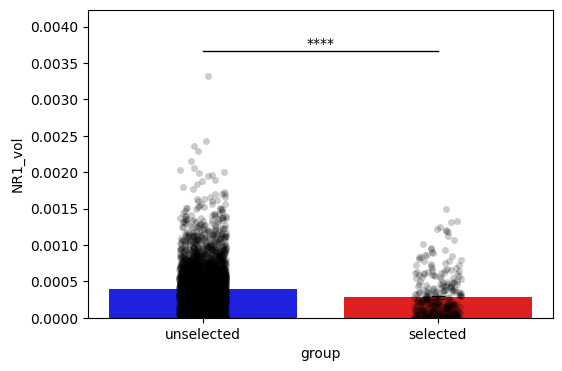

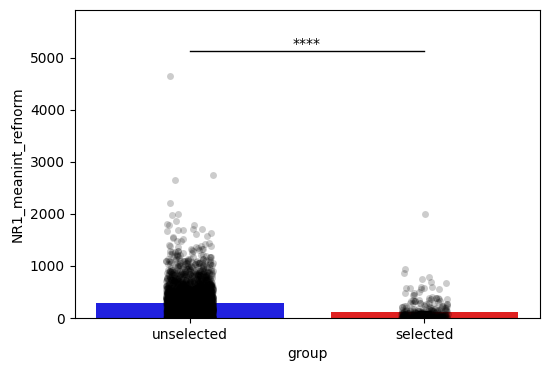

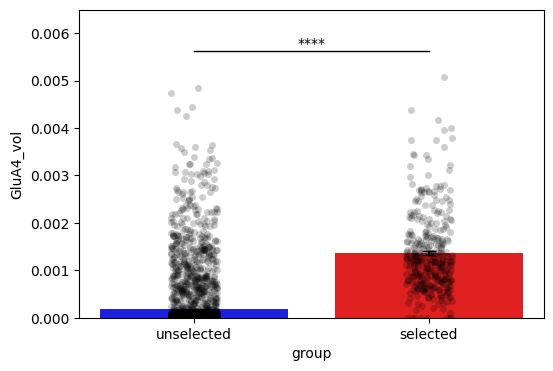

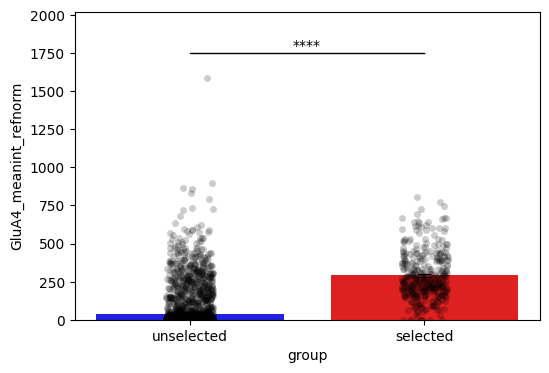

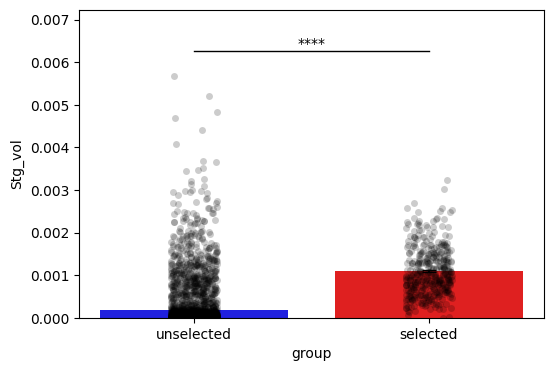

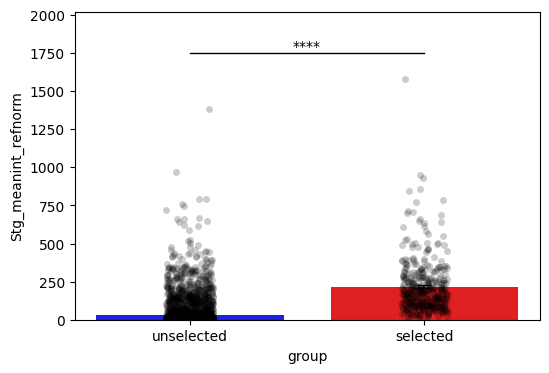

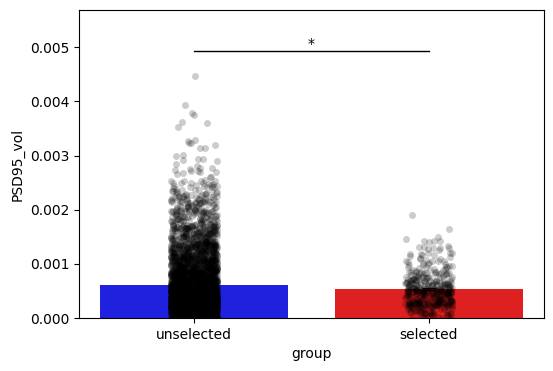

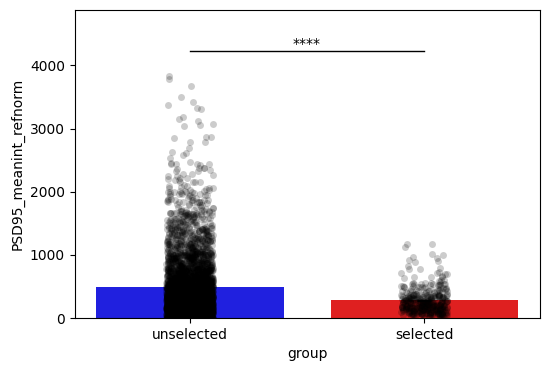

In [138]:
# Code generated by ChatGPT (4.0) on 6/9/24 by MES, also modified by MES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Identify numerical columns in 'data_ca1'
numerical_columns = data_ca1.select_dtypes(include='number').columns

# Get unique values of 'group'
types = data_ca1['group'].unique()

# Function to calculate SEM
def sem(x):
    return stats.sem(x, nan_policy='omit')

# Function to determine the number of asterisks based on p-value
def get_significance_asterisks(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create bar plots for each numerical variable
for prot in prots:
    for col in values:
        data_temp = data_ca1[data_ca1['prot']==prot]
        plt.figure(figsize=(6, 4))
        ax = sns.barplot(x='group', y=col, data=data_temp, ci=None, palette=group_colors)  # Suppress default error bars
        
        # Add individual data_ca1 points
        sns.stripplot(x='group', y=col, data=data_temp, color='black', size=5, jitter=True, ax=ax, alpha = 0.2)
        
        # Calculate and plot error bars (mean ± SEM)
        means = data_temp.groupby('group')[col].mean()
        sems = data_temp.groupby('group')[col].apply(sem)
        for i, type_val in enumerate(types):
           plt.errorbar(i, means[type_val], yerr=sems[type_val], fmt='none', c='black', capsize=5)
    
        # Add significance asterisks if applicable
        if len(col.split("_")) > 2:
            value_name = prot + '_' + col.split("_")[1] + '_' + col.split("_")[2]
        else:
            value_name = prot + '_' + col.split("_")[1]
        
        if value_name in pvals_df.index and pvals_df.loc[value_name, 'significant'] == True:
            p_value = pvals_df.loc[value_name, 'p_adjusted']
            asterisks = get_significance_asterisks(p_value)
            if asterisks:
                max_y = data_temp[col].max()
                # Position the asterisks above the highest data_temp point
                y = max_y + sems.max() + 0.1 * max_y
                plt.plot([0, 1], [y, y], color='black', lw=1)  # horizontal line
                plt.text(0.5, y, asterisks, ha='center', va='bottom', color='black')
    
        # Adjust y-axis to add space for asterisks
        current_ylim = plt.ylim()
        plt.ylim(current_ylim[0], current_ylim[1] * 1.1)
    
        plt.grid(False) #remove gridlines
        
        # Set plot title and labels
        # plt.title(f'Bar Plot for {col}')
        #plt.xlabel('Group')
        plt.ylabel(value_name)
    
        # Save plot
        plt.savefig(parentdir + '/CA1_barplots/' + col + '_' + prot + '.svg',dpi=800,bbox_inches='tight')
        plt.savefig(parentdir + '/CA1_barplots/' + col + '_' + prot + '.png',dpi=800,bbox_inches='tight')
        
        # Show plot
        plt.show()

# Save down data as .csv to folder to combine with other datasets

In [139]:
data.to_csv('/Users/margaret/Dropbox (MIT)/mExR_analysis/SmallData/multiExR_PV_synapses/PV_vs_Thy1_combined/PV_GFP_5target.csv')